In [1]:
# ============================================================
# Impact of Severity Quantile Schemes on CatBoost Classification
# ------------------------------------------------------------
# This script investigates how different quantile-based severity
# labeling schemes affect the performance of a CatBoost
# multiclass classifier for thermal runaway (TR) severity.
#
# Workflow:
#   1. Load and filter the FTRC dataset (SOC = 100%)
#   2. Construct a Severity Index (SI)
#   3. Generate severity labels using multiple quantile schemes
#   4. Train CatBoost models with class-weighted learning
#   5. Evaluate performance via cross-validation and test split
#
# Outputs:
#   - Accuracy, Macro-F1, High-severity recall per scheme
#   - Normalized confusion matrices for each scheme
#
# Notes:
#   - Model hyperparameters are fixed across schemes
#   - Only the labeling strategy is varied
# ============================================================

# =========================
# 0. Imports & Settings
# =========================
import warnings
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

from catboost import CatBoostClassifier, Pool

from src.data import FTRC_Data
import numpy as np 

warnings.filterwarnings("ignore")

# =========================
# 1. Load and Filter Dataset
# =========================
print("Loading FTRC dataset...")

data = FTRC_Data()

# Keep only fully charged cells (SOC = 100%)
data.df = data.df[data.df["Pre-Test-State-of-Charge-%"] == 100]

def cylinder_volume_L(code):
    code = int(code)
    
    diameter = code // 1000
    height = (code % 1000)/10
    
    radius = diameter / 2
    
    volume_mm3 = np.pi * (radius**2) * height
    
    return volume_mm3 / 1e6   # 转成 L

data.df["Cell_Volume_L"] = data.df["Geometry"].apply(cylinder_volume_L)
data.df["Volumetric-Energy-Density-Wh/L"] = data.df['Cell-Energy-Wh']/data.df["Cell_Volume_L"] 

data.df["Gravimetric-Energy-Density-Wh/kg"]=data.df['Cell-Energy-Wh']/data.df['Pre-Test-Cell-Mass-g']*1000




# Metadata features used for classification
FEATURES_METADATA = [
    "Cell-Description",
    "Manufacturer",
    "Geometry",
    "Cell-Capacity-Ah",
    "Trigger-Mechanism", 
    "Bottom-Vent-Yes-No","Gravimetric-Energy-Density-Wh/kg","Volumetric-Energy-Density-Wh/L"
]

X = data.df[FEATURES_METADATA].copy()

# =========================
# 2. Severity Index Construction
# =========================
print("Computing Severity Index (SI)...")

# Max-normalization of contributing terms
data.df["Total Heat Output [kJ/A*h]"] /= data.df["Total Heat Output [kJ/A*h]"].max()
data.df["Total-Mass-Ejected-g"] /= data.df["Total-Mass-Ejected-g"].max()
data.df["Negative-Mass-Ejected-g"] /= data.df["Negative-Mass-Ejected-g"].max()

# Equal-weight severity index
SI = (
    0.25 * data.df["Total Heat Output [kJ/A*h]"]
    + 0.25 * data.df["Total-Mass-Ejected-g"]
    + 0.25 * data.df["Negative-Mass-Ejected-g"]
    + 0.25 * data.df["Total Ejected Mass Fraction [g/g]"]
)

# =========================
# 3. Categorical Feature Specification
# =========================
CATEGORICAL_COLS = [
    "Cell-Description",
    "Manufacturer",
    "Geometry",
    "Trigger-Mechanism",
    "Bottom-Vent-Yes-No"
]


for col in CATEGORICAL_COLS:
    X[col] = X[col].astype(str)

cat_feature_indices = [X.columns.get_loc(col) for col in CATEGORICAL_COLS]

print("Categorical features:", CATEGORICAL_COLS)
print("Categorical feature indices:", cat_feature_indices)

# =========================
# 4. Quantile-Based Labeling Schemes
# =========================
quantile_schemes = {
    "A": [0.00, 0.15, 0.85, 1.00],
    "B": [0.00, 0.20, 0.80, 1.00],
    "C": [0.00, 0.30, 0.70, 1.00],
    "D": [0.00, 0.33, 0.66, 1.00],
}

scheme_metrics = {}
confusion_matrices = {}
label_distributions = {}

# =========================
# 5. Loop Over Quantile Schemes
# =========================
for scheme, q in quantile_schemes.items():

    print(f"\n=== Quantile Scheme {scheme}: {q} ===")

    # Generate severity labels (Low / Medium / High)
    y = pd.qcut(
        SI,
        q=q,
        labels=["Low", "Medium", "High"],
        duplicates="drop",
    )

    # Store label distribution
    label_distributions[scheme] = (
        y.value_counts(normalize=True)
        .reindex(["Low", "Medium", "High"])
        .fillna(0)
    )

    # ---------------------
    # Train / Test Split
    # ---------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    # ---------------------
    # Class Weights
    # ---------------------
    class_counts = Counter(y_train)
    classes = sorted(class_counts.keys())

    total_samples = len(y_train)
    n_classes = len(classes)

    class_weights = [
        total_samples / (n_classes * class_counts[c]) for c in classes
    ]

    print("Training class distribution:", class_counts)
    print("Class weights:", class_weights)

    # ---------------------
    # CatBoost Pools
    # ---------------------
    train_pool = Pool(
        X_train,
        label=y_train,
        cat_features=cat_feature_indices,
    )
    test_pool = Pool(
        X_test,
        label=y_test,
        cat_features=cat_feature_indices,
    )

    # ---------------------
    # 5-Fold Cross-Validation
    # ---------------------
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_acc = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        train_pool_cv = Pool(
            X.iloc[tr_idx],
            y.iloc[tr_idx],
            cat_features=cat_feature_indices,
        )
        val_pool_cv = Pool(
            X.iloc[val_idx],
            y.iloc[val_idx],
            cat_features=cat_feature_indices,
        )

        model_cv = CatBoostClassifier(
            loss_function="MultiClass",
            eval_metric="MultiClass",
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=10,
            iterations=1500,
            random_seed=fold,
            od_type="Iter",
            od_wait=80,
            class_weights=class_weights,
            verbose=False,
        )

        model_cv.fit(train_pool_cv, eval_set=val_pool_cv, use_best_model=True)
        preds_val = model_cv.predict(val_pool_cv)
        cv_acc.append(accuracy_score(y.iloc[val_idx], preds_val))

    print(f"CV accuracy: {np.mean(cv_acc):.3f} ± {np.std(cv_acc):.3f}")

    # ---------------------
    # Final Training & Test
    # ---------------------
    final_model = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="MultiClass",
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=10,
        iterations=1500,
        random_seed=42,
        od_type="Iter",
        od_wait=80,
        class_weights=class_weights,
        verbose=False,
    )

    final_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

    y_pred = final_model.predict(test_pool)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    if (y == "High").sum() == 0:
        recall_high = np.nan
    else:
        recall_high = recall_score(
            y_test,
            y_pred,
            labels=["High"],
            average=None,
            zero_division=0,
        )[0]

    scheme_metrics[scheme] = {
        "Accuracy": acc,
        "Macro-F1": f1_macro,
        "High Recall": recall_high,
    }

    print(
        f"Test Acc={acc:.3f}, Macro-F1={f1_macro:.3f}, High Recall={recall_high:.3f}"
    )

    # Normalized confusion matrix
    cm = confusion_matrix(
        y_test,
        y_pred,
        labels=["Low", "Medium", "High"],
        normalize="true",
    )

    confusion_matrices[scheme] = cm

print("\nCompleted evaluation across all quantile schemes.")


Loading FTRC dataset...
Computing Severity Index (SI)...
Categorical features: ['Cell-Description', 'Manufacturer', 'Geometry', 'Trigger-Mechanism', 'Bottom-Vent-Yes-No']
Categorical feature indices: [0, 1, 2, 4, 5]

=== Quantile Scheme A: [0.0, 0.15, 0.85, 1.0] ===
Training class distribution: Counter({'Medium': 176, 'Low': 38, 'High': 37})
Class weights: [2.2612612612612613, 2.2017543859649122, 0.4753787878787879]
CV accuracy: 0.755 ± 0.114
Test Acc=0.810, Macro-F1=0.781, High Recall=1.000

=== Quantile Scheme B: [0.0, 0.2, 0.8, 1.0] ===
Training class distribution: Counter({'Medium': 150, 'Low': 51, 'High': 50})
Class weights: [1.6733333333333333, 1.6405228758169934, 0.5577777777777778]
CV accuracy: 0.732 ± 0.052
Test Acc=0.667, Macro-F1=0.684, High Recall=1.000

=== Quantile Scheme C: [0.0, 0.3, 0.7, 1.0] ===
Training class distribution: Counter({'Medium': 101, 'High': 75, 'Low': 75})
Class weights: [1.1155555555555556, 1.1155555555555556, 0.8283828382838284]
CV accuracy: 0.704 ± 0


===== Sensitivity Analysis Results =====
   Accuracy  Macro-F1  High Recall
A  0.809524  0.780886     1.000000
B  0.666667  0.684109     1.000000
C  0.603175  0.612439     0.789474
D  0.619048  0.620700     0.809524


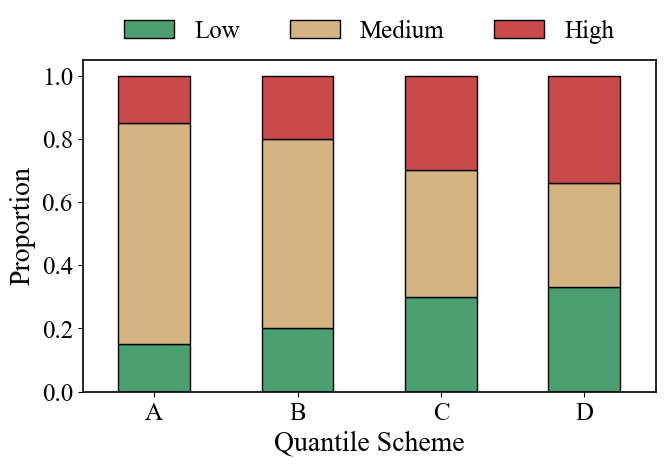

In [2]:
# ============================================================
# Visualization of Sensitivity Analysis Results
# ------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. Results Table
# =========================
results_df = pd.DataFrame(scheme_metrics).T


print("\n===== Sensitivity Analysis Results =====")
print(results_df)

# =========================
# 2. Visualization Settings
# =========================
# Academic color palette (severity gradient)
COLORS = {
    "Low": "#4C9F70",      # muted green (safe, stable)
    "Medium": "#D4B483",   # desaturated sand / khaki
    "High": "#C94A4A",     # muted red (hazard, not aggressive)
}

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "axes.linewidth": 1.0,
})

# =========================
# 3. Severity Proportion Plot
# =========================
# Rows: quantile schemes; Columns: Low / Medium / High
proportion_df = pd.DataFrame(label_distributions).T[["Low", "Medium", "High"]]

fig, ax = plt.subplots(figsize=(7, 5))

proportion_df.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=[COLORS[c] for c in proportion_df.columns],
    edgecolor="black",
    linewidth=1.0,
)

ax.set_ylabel("Proportion")
ax.set_xticklabels(proportion_df.index, rotation=0)
ax.set_xlabel("Quantile Scheme")
# Legend placed above the plot
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.98),
    ncol=len(proportion_df.columns),
    frameon=False,
)

# Black frame around axes
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig(
    "imgs/Sensitivity analysis/Severity_Distribution_Under_Different_Quantile_Schemes.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()


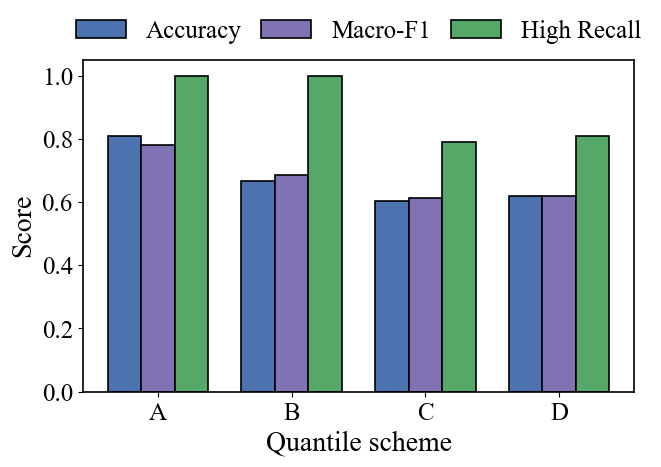

In [3]:
# ============================================================
# Bar Chart: Model Performance Under Different Quantile Schemes
# ------------------------------------------------------------
# This figure compares classification performance metrics
# (Accuracy, Macro-F1, and High-severity Recall) across
# different quantile-based severity labeling schemes.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# Color palette (academic style)
# ---------------------
COLORS = {
    "Accuracy":   "#4C72B0",  # blue
    "Macro-F1":   "#8172B3",  # orange
    "High Recall":"#55A868",  # green
}

# ---------------------
# Bar layout
# ---------------------
x = np.arange(len(results_df.index))   # positions on x-axis
bar_width = 0.25

# ---------------------
# Plot
# ---------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(
    x - bar_width,
    results_df["Accuracy"],
    bar_width,
    label="Accuracy",
    color=COLORS["Accuracy"],
    edgecolor="black",
    linewidth=1.2,
)

ax.bar(
    x,
    results_df["Macro-F1"],
    bar_width,
    label="Macro-F1",
    color=COLORS["Macro-F1"],
    edgecolor="black",
    linewidth=1.2,
)

ax.bar(
    x + bar_width,
    results_df["High Recall"],
    bar_width,
    label="High Recall",
    color=COLORS["High Recall"],
    edgecolor="black",
    linewidth=1.2,
)

# ---------------------
# Axes & labels
# ---------------------
ax.set_xticks(x)
ax.set_xticklabels(results_df.index)
ax.set_xlabel("Quantile scheme")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)

# ---------------------
# Legend (top-centered, no frame)
# ---------------------
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.98),
    ncol=3,
    frameon=False,
    columnspacing=0.8,
)

# ---------------------
# Axis frame styling
# ---------------------
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

plt.tight_layout()

plt.savefig(
    "imgs/Sensitivity analysis/Model_Performance_Under_Different_Quantile_Schemes.png",
    dpi=600,
    bbox_inches="tight",
)

plt.show()


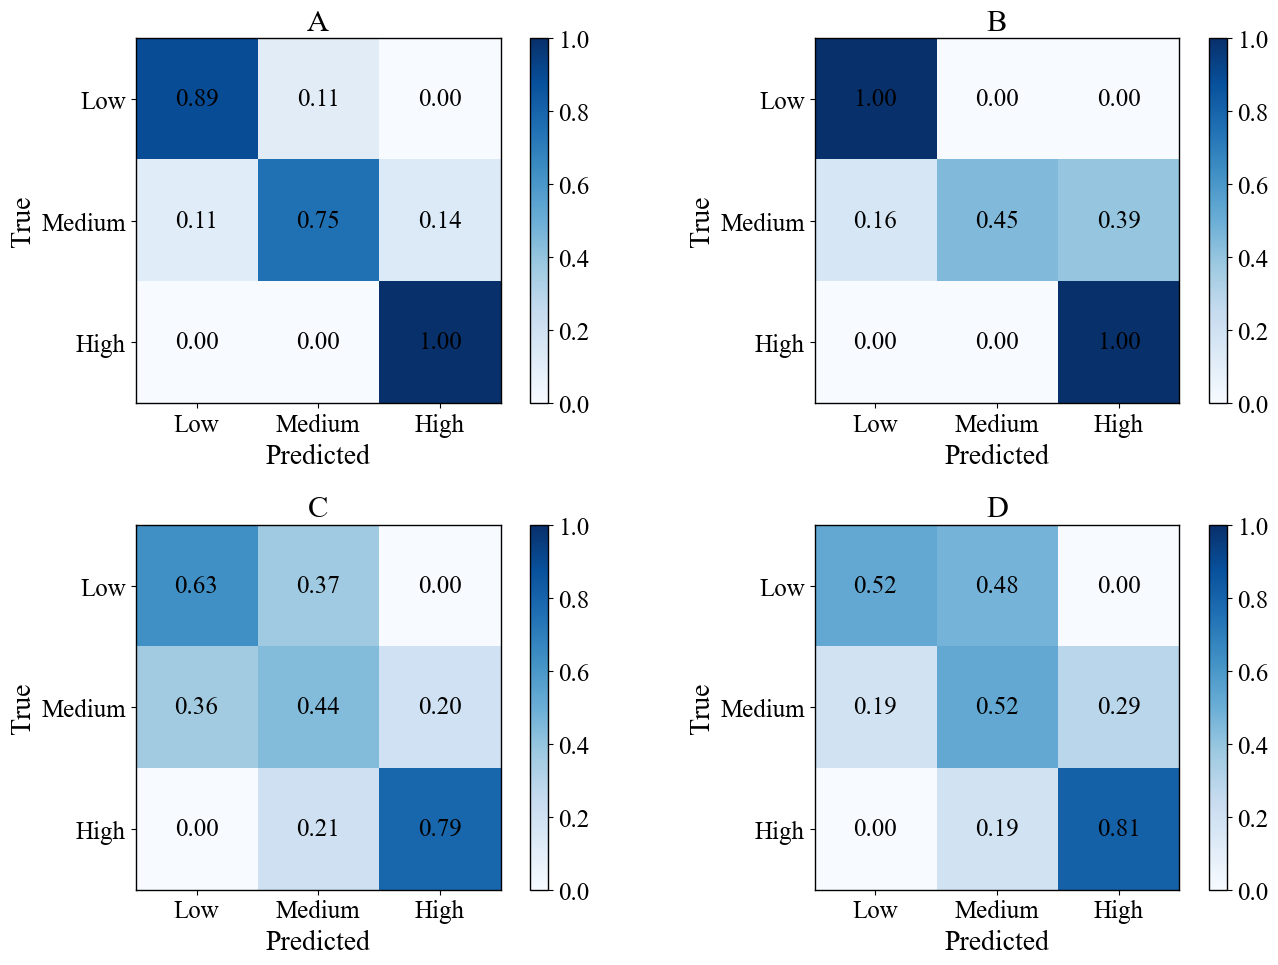

In [5]:

# ======================================================
# Visualization of confusion matrices
# ======================================================
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams["font.family"] = "Times New Roman"
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, scheme_name in zip(axes, quantile_schemes.keys()):
    cm = confusion_matrices[scheme_name]

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Low","Medium","High"]
    )

    disp.plot(
        ax=ax,
        cmap="Blues",   #magma,viridis
        colorbar=True,
        values_format=".2f",
        text_kw={"color": "black"}
    )
    disp.im_.set_clim(0, 1)

    ax.set_title(f"{scheme_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.savefig("imgs/Sensitivity analysis/Confusion_Matrix.png", dpi=600, bbox_inches="tight")
plt.show()